In [1]:
#подключим нужные библиотеки и читаем данные


import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

import hashlib
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
# from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.model_selection import train_test_split
from tensorflow import keras
from scipy.ndimage import rotate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
import re
from finta import TA
import tensorflow as tf
import random 

import warnings
warnings.simplefilter(action='ignore', category=Warning)
pd.reset_option('all')

In [2]:
from tensorflow.python.client import device_lib 
# CUDA_VISIBLE_DEVICES = 0
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 902362693600090404
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6296698880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6731327503592831068
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import os.path
import time
import re
import ast
def get_time():                          
    ttt=(str("{}-{}-{}_{}-{}".format(time.localtime().tm_year, time.localtime().tm_mon,
                                             time.localtime().tm_mday, time.localtime().tm_hour,
                                             time.localtime().tm_min, )))
    return ttt
# print(get_time())

def write_in_file(file_name,text_in, *args,need_time = True ):
    file_name = re.sub(r'\\|\:|\*|\?|\"|\<|\>|\|',"",file_name, count=0)
    file = open(file_name, "w", encoding="utf-8")
    # print(type(text_in))
    # print(text_in)
    file.write(str(text_in))
    # file.writelines(text_in)
    if need_time == True:
        file.write(str(get_time()))
        file.write('\n')
    for each in args:
        file.write(str(each))
    file.write('\n\n')
    file.close()




def log(folder_name,file_name, *args,need_time = True ):
    if type(re.search(r"\.", file_name, flags=re.MULTILINE))==None:
        file_name = file_name+".txt"
    text_in = ''
    file_name = re.sub(r'\\|\/|\:|\*|\?|\"|\<|\>|\|', "", file_name, count=0)

    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

    done_flag = False
    while done_flag==False:
        try:
            if os.path.exists(folder_name+"/"+file_name) == False:
                write_in_file(folder_name+"/"+file_name, text_in, args, need_time)
            else:
                file = open(folder_name+"/"+file_name, "r", encoding="utf-8")
                text_in = file.read()
                file.close()
                write_in_file(folder_name+"/"+file_name,text_in, args,need_time)


            print("logged ", file_name)
            done_flag=True
        except Exception as e:

            print('logging failed', e)
            time.sleep(0.4)

In [4]:

def DataPreprocessing(data, candlesNNSee=25, candlesItPredict=1, daysInSingleLable=1, makeLabelsCountEqual=True):
    columnsToDelete = [0, 6]
    data = data.drop(data.columns[columnsToDelete], axis=1)
    data = data.reset_index()  # добавим колонку с индексами

    def Organize_ohlcv(data):
        cols = list(data.columns)
        index, Low, Open, Volume, High, Close = cols.index('index'), cols.index('Low'), cols.index('Open'), cols.index(
            'Volume'), cols.index('High'), cols.index('Close')
        cols[index], cols[Low], cols[Open], cols[Volume], cols[High], cols[Close] = cols[index], cols[Open], cols[High], \
                                                                                    cols[Low], cols[Close], cols[Volume]
        data = data[cols]
        return data

    data = Organize_ohlcv(data)
    data.columns = ['index', 'open', 'high', 'low', 'close', 'volume']  # rename


    SMAb = TA.SMA(data, 100)  # Simple Moving Average
    DEMAb = TA.DEMA(data)  # Double Exponential Moving Average
    RSIb = TA.RSI(data)  # Relative Strenght Index  не понятно, найдет ли нейросеть на нём паттерны вообще
    TRIMAb = TA.TRIMA(data)  # Triangular Moving Average   !!!!
    KAMAb = TA.KAMA(data)  # Kaufman's Adaptive Moving Average '!!!
    ATRb = TA.ATR(data)  # Average True Range

    
    SMAb = SMAb.to_frame()
    DEMAb = DEMAb.to_frame()
    RSIb = RSIb.to_frame()
    TRIMAb = TRIMAb.to_frame()
    KAMAb = KAMAb.to_frame()
    ATRb = ATRb.to_frame()
    

    # print(data.isnull().sum())

    # сделаем цены в процентах от предыдущего дня, а не просто значения
    def percent(thisNum, fromBase):
        if fromBase <= 0.1:
            fromBase = thisNum / 10
        if thisNum <= 0.1:
            thisNum = fromBase / 10
        try:
            return (100 / (fromBase / thisNum)) - 100
        except:
            if fromBase <= 0.1:
                fromBase = thisNum / 10
            if thisNum <= 0.1:
                thisNum = fromBase / 10
            return (100 / (fromBase / thisNum)) - 100

    def makePercented(data):
        dt = data.copy()
        columns = range(len(list(data)))
        for i in columns:
            if i == 0:
                continue
            for index, row in data.iterrows():
                if index == 0:
                    continue
                N = percent(data.iloc[index, i], data.iloc[index - 1, i])
                dt.iloc[index, i] = N
        return dt

    data = makePercented(data)

    # добавим колонку с категориями, которые мы будем в итоге угадывать (но тут они пока свои на строку)
    def Average(array):
        summed = 0
        for each in array:
            summed += each
        return summed / len(array)

    def averageLine(data, columns, NLinesToAverage):
        if NLinesToAverage == 1:
            NLinesToAverage = 1
        data['Averaged'] = 0
        for index, row in data.iterrows():
            if index + NLinesToAverage > len(data):
                NLinesToAverage = len(data) - index
            arrayToCount = []
            for lines in range(NLinesToAverage):
                for elemntInLine in columns:
                    arrayToCount.append(data.iloc[index + lines, elemntInLine])
            data["Averaged"][index] = Average(arrayToCount)
        return data

    def CatFour(Num, catMin, catMax):  # четыре категории - сильно рост, слабо рост. Сильное падение, слабое падение
        if 0 < Num < catMax:
            return 2
        elif Num > catMax:
            return 3
        elif 0 >= Num > catMin:
            return 1
        elif Num < catMin:
            return 0

    def addCategorical(data, column, borderPercent):
        borderPercent = borderPercent  # 1% и -1% будут границей, больше и меньше которой интересные категории. а внутри неинтересные - мало движения потому-что
        data['catLabels'] = 0
        for index, row in data.iterrows():
            data["catLabels"][index] = CatFour(data.iloc[index, column], -borderPercent, borderPercent)
        return data

    data = averageLine(data, [1, 2, 3, 4], daysInSingleLable)
    columnindex = list(data.columns).index("Averaged")# индекс колонки по которой будут считаться категории. Если не добавлять дополнительные параметры, то 6
    borderPercent = 1
    data = addCategorical(data, columnindex, borderPercent)

    
    # воткнем значения технического анализа
    # те, которые b - до процентов
    # те, котрые без b - посчитаны уже по процентам


    SMAb = makePercented(SMAb)
    DEMAb = makePercented(DEMAb)
    RSIb = makePercented(RSIb)
    TRIMAb = makePercented(TRIMAb)
    KAMAb = makePercented(KAMAb)
    ATRb = makePercented(ATRb)


    # тоже самое, только теперь расчет от процентов
    SMA = TA.SMA(data, 100)  # Simple Moving Average
    OBV = TA.OBV(data)  # On Balance Volume
    DEMA = TA.DEMA(data)  # Double Exponential Moving Average
    TRIMA = TA.TRIMA(data)  # Triangular Moving Average   !!!!
    KAMA = TA.KAMA(data)  # Kaufman's Adaptive Moving Average '!!!


    # добавляем индикаторы к данным
    data['SMAb'] = SMAb
    data['SMA'] = SMA
    data['OBV'] = OBV
    data['DEMAb'] = DEMAb
    data['DEMA'] = DEMA
    data['RSIb'] = RSIb
    data['TRIMAb'] = TRIMAb
    data['TRIMA'] = TRIMA
    data['KAMAb'] = KAMAb
    data['KAMA'] = KAMA
    data['ATRb'] = ATRb
    # data['TSIb'] = TSIb
    # data['TSI'] = TSI
    # data[''] = 
    
    
    data = data.interpolate()# интерполируем значения, чтоб избежать NaN значений от функций тех.Анализа
    # но вообще OBV наверное стоит убрать, раз он делает нан
    
    data = data[100:]  # убираем первую сотню всего потому, что SMA не вписывает туда значения
    columnsToDelete = [0]  # удалим индекс
    data = data.drop(data.columns[columnsToDelete], axis=1)

    # log('log_folder','log_file',arg1,arg2,argN)
    # print("Количество NAN значений в данных ", sum(data.isnull().sum()))
    # print(data.isnull().sum())
    

    if not np.all(np.isfinite(data.values)):
        log('log_folder','log_file',str(np.isfinite(data.values)))
        # print(data.isfinite().sum())
        return "NOTisfiniteNumsFound", "NOTisfiniteNumsFound"
    
    # нормализуем фичи
    def makeItNormed(data):
        min_max_scaler = preprocessing.MinMaxScaler()
        df_norm = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns)
        return df_norm
        
    # def makeItNormed(data):
    #     x = data.values  # returns a numpy array
    #     min_max_scaler = preprocessing.MinMaxScaler()
    #     x_scaled = min_max_scaler.fit_transform(x)
    #     return pd.DataFrame(x_scaled)

    dataNormed = makeItNormed(data)
    

    
    # print("len(data)", len(data),"len(dataNormed)", len(dataNormed))

    # функция, которая отдает все варианты лэйблов в конкретной колонке
    def countAllTypes(data, name):
        spisok = []
        for index, row in data.iterrows():
            labelType = row[name]
            if labelType in spisok:
                pass
            else:
                spisok.append(labelType)
        return spisok

    labelCount = len(countAllTypes(data, "catLabels"))
    allLabels = countAllTypes(data, "catLabels")

    # print("всего лэйблов ", labelCount, "все варианты лэйблов ", allLabels)

    # print(type(data),type(dataNormed))
    # dataNormed.plot()
    
    
    

    def makeLabels(data, candlesNNSee, candlesItPredict, labelsColumn):
        # следующие две строки нужны потому, что иначе он делает багу и стартует не от-туда, а прям по индексам.
        data = data.reset_index()
        data = data.drop(data.columns[[0]], axis=1) # можно не делать. Один черт лэйблы получаем
        data = data[labelsColumn]
        temp = data[candlesNNSee:candlesNNSee + candlesItPredict]
        temp.to_numpy()
        ArrImOur = np.array([temp])
        ArrImOur = ArrImOur.astype(np.int8)
        for index, row in data.iteritems():
            if index <= candlesNNSee:
                continue
            if index + candlesItPredict > len(data):
                break
            temp = data[index:index + candlesItPredict]
            temp.to_numpy()
            ArrImOur = np.vstack((ArrImOur, [temp]))
            ArrImOur = ArrImOur.astype(np.int8)
        return ArrImOur

    labels = makeLabels(data, candlesNNSee, candlesItPredict, 'catLabels')

    def makeFeatures(data, candlesNNSee, candlesItPredict):
        # следующие две строки нужны потому, что иначе он делает багу и стартует не от-туда, а прям по индексам.
        data = data.reset_index()
        data = data.drop(data.columns[[0]], axis=1)
        # поскольку мы показываем итоговой нейросети сразу картинку - множество дней, то тут мы создаем np массив и заполняем его первым элементом нужного размера
        temp = data[0:candlesNNSee]
        temp.to_numpy()
        ArrImOur = np.array([temp])
        data = data[:len(data) - candlesItPredict + 1]
        # дальше мы заполняем массивами после первого, но первый пропускаем, поэтому тут if
        for index, row in data.iterrows():
            if index <= candlesNNSee:
                continue
            temp = data[index - candlesNNSee:index]  # отрезок от старта до сейчас.
            temp.to_numpy()
            ArrImOur = np.vstack((ArrImOur, [temp]))  # добавили картинку в конец массива
        return ArrImOur


    features = makeFeatures(dataNormed, candlesNNSee, candlesItPredict)
    
    if np.any(np.isnan(labels)) or np.any(np.isnan(features)):
        log('log_folder','log_file',str(data.isnull().sum()))
        print(data.isnull().sum())
        return "NanNumsFound", "NanNumsFound"
    
    # assert not np.any(np.isnan(labels))
    # assert not np.any(np.isnan(features))    

    def makeItDF(data):
        typ = str(type(data))
        if typ == "<class 'numpy.ndarray'>":
            data = pd.DataFrame(data)
        if typ == "<class 'pandas.core.frame.DataFrame'>":
            pass
        return data

    def makeItNP(data):
        typ = str(type(data))
        if typ == "<class 'numpy.ndarray'>":
            pass
        if typ == "<class 'pandas.core.frame.DataFrame'>":
            data.to_numpy()
        return data

    def giveMeRawsWhereTheeseTypes(data, labelTypes, itsColumn):
        data = makeItDF(data)
        listOfIndexes = []
        for index, row in data.iterrows():
            if row[0] in labelTypes:
                listOfIndexes.append(int(index))
        return listOfIndexes

    def dropTheeseIndexes(data, listOfIndexes):
        typ = str(type(data))
        if typ == "<class 'numpy.ndarray'>":
            data = np.delete(data, listOfIndexes, 0)
        if typ == "<class 'pandas.core.frame.DataFrame'>":
            data = data.drop(index=listOfIndexes)
        data = makeItNP(data)
        return data

    def EqualizeLabels(labels,
                       features):  # выравниваем датасет чтоб количество лэйблов каждого типа было равным. сейчас работает только если 1 лэйбл
        targetLabeCount = int(min(pd.DataFrame(labels)[0].value_counts()))
        counter = 0  # каунтер тут нужен для того, чтоб указывать на категории (0,1,2,3)
        for each in pd.DataFrame(labels).value_counts():
            if each >= targetLabeCount:
                listOfIndexes = giveMeRawsWhereTheeseTypes(labels, [counter], 0)
                features = dropTheeseIndexes(features, listOfIndexes[targetLabeCount:])
                labels = dropTheeseIndexes(labels, listOfIndexes[targetLabeCount:])
            counter += 1
        # print("количество элементов каждого класса \n", pd.DataFrame(labels)[0].value_counts())
        return labels, features

    if makeLabelsCountEqual == True:
        labels, features = EqualizeLabels(labels, features)
    return labels, features
    pass


# data = pandas.read_csv("FB.csv")
# templabels, tempfeatures = DataPreprocessing(data)            

In [5]:
import os
import re
import random 
import sys

def reformatTrainData(StonksList,shuffle=True, batchWeight=1000 , candlesNNSee=25, candlesItPredict=1, daysInSingleLable=1, makeLabelsCountEqual=True):
    if shuffle == True:
        random.shuffle(StonksList)
    labels = None
    features = None
    
    # функция генератора на всякий случай
    def addor(StonksList):
        for stonkName in StonksList:
            templabels, tempfeatures = DataPreprocessing(pandas.read_csv(stonkName), candlesNNSee, candlesItPredict, daysInSingleLable, makeLabelsCountEqual)
            if templabels == "NanNumsFound" or tempfeatures == "NanNumsFound" or templabels == "NOTisfiniteNumsFound" or tempfeatures == "NOTisfiniteNumsFound":
                print(str(stonkName))
                log('log_folder','log_file',str(stonkName))
                continue
            yield templabels, tempfeatures, stonkName
    
    for templabels, tempfeatures, stonkName in addor(StonksList):
        try:
            labels = np.vstack((labels, templabels))
            features = np.vstack((features, tempfeatures))
        except:
            labels= templabels
            features = tempfeatures
        if round(sys.getsizeof(features)/1024/1024,2) > batchWeight:
            return labels, features
    return labels, features
    
    
def giveListOfCSV(folderName):
    StocksList = []
    for dirpath, dirnames, filenames in os.walk(folderName):
        for filename in filenames:
            StocksList.append(str(os.path.join(dirpath, filename)))
    for each in StocksList:
        if not re.search(r".+[?=csv]", each, flags=re.MULTILINE):
            StocksList.remove(each)
    return StocksList

StocksList = giveListOfCSV("stock_market_data")
labels, features = reformatTrainData(StocksList,shuffle=True, batchWeight=1500 , candlesNNSee=60, candlesItPredict=1, daysInSingleLable=1, makeLabelsCountEqual=True)


print("features:",round(sys.getsizeof(features)/1024/1024,2), "mb")


logged  log_file
stock_market_data\nasdaq\NDSN.csv
logged  log_file
logged  log_file
stock_market_data\nasdaq\ANCX.csv
logged  log_file
logged  log_file
stock_market_data\nasdaq\TOPS.csv
logged  log_file
logged  log_file
stock_market_data\nyse\APB.csv
logged  log_file
features: 1559.98 mb


features: 1559.98 mb
спрашиваем с нейросети категорию:  [0]  а показываем:


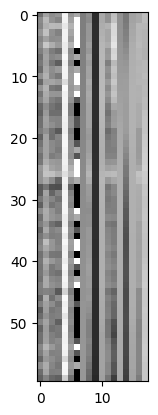

In [6]:
import sys
print("features:",round(sys.getsizeof(features)/1024/1024,2), "mb")
which = -1
plt.imshow(features[which],cmap = plt.cm.binary)
print("спрашиваем с нейросети категорию: ",labels[which], " а показываем:")

In [7]:
inputUnits = int(features.shape[1])*int(features.shape[2])
labelCount = 4
print("inputUnits ",inputUnits)

inputUnits  1080


In [8]:
model = Sequential()

model.add(keras.layers.Dense(units = inputUnits,batch_input_shape=(None,int(features.shape[1]),int(features.shape[2])), activation=tf.keras.activations.sigmoid))

model.add(keras.layers.LSTM(units = inputUnits*2, activation=tf.keras.activations.sigmoid,return_sequences=False))

# model.add(tf.keras.layers.Flatten())
model.add(keras.layers.Dense(units = labelCount, activation=tf.keras.activations.sigmoid))

sgd = SGD(learning_rate=0.2, decay=1e-6, momentum=0.5, nesterov=False)

model.compile(loss='sparse_categorical_crossentropy', optimizer = "adam",metrics=['accuracy'])

epochCount = 30
history = model.fit(features, labels, epochs=epochCount)

#проведем оценку модели
val_loss,val_acc= model.evaluate(features,labels)
print("Нейросеть тыкнула в категорию правильно в:",val_acc*100,"% случаях (accuracy). Разница между единицей верного варианта и вероятностью, которую дала для него нейросеть ",val_loss*100,"% (loss) на всём датасете ")
print("Если нейросеть будет тыкать только в самый частый лэйбл, то accuracy будет ",100/(sum(pd.DataFrame(labels)[0].value_counts())/max(pd.DataFrame(labels)[0].value_counts())))
model.save('model' + get_time()+' accuracy '+str(val_acc)+' loss '+str(val_loss))

Epoch 1/30
5917/5917 [==============================] - 1660s 280ms/step - loss: 1.3907 - accuracy: 0.2916
Epoch 2/30
5917/5917 [==============================] - 1656s 280ms/step - loss: 1.3461 - accuracy: 0.3474
Epoch 3/30
5917/5917 [==============================] - 1642s 278ms/step - loss: 1.3196 - accuracy: 0.3674
Epoch 4/30
5917/5917 [==============================] - 1651s 279ms/step - loss: 1.3071 - accuracy: 0.3797
Epoch 5/30
5917/5917 [==============================] - 1662s 281ms/step - loss: 1.3015 - accuracy: 0.3829
Epoch 6/30
5917/5917 [==============================] - 1655s 280ms/step - loss: 1.2960 - accuracy: 0.3885
Epoch 7/30
5917/5917 [==============================] - 1674s 283ms/step - loss: 1.2932 - accuracy: 0.3899
Epoch 8/30
5917/5917 [==============================] - 1651s 279ms/step - loss: 1.2901 - accuracy: 0.3931
Epoch 9/30
5917/5917 [==============================] - 1655s 280ms/step - loss: 1.2863 - accuracy: 0.3959
Epoch 10/30
5917/5917 [==============

5917/5917 [==============================] - 222s 37ms/step


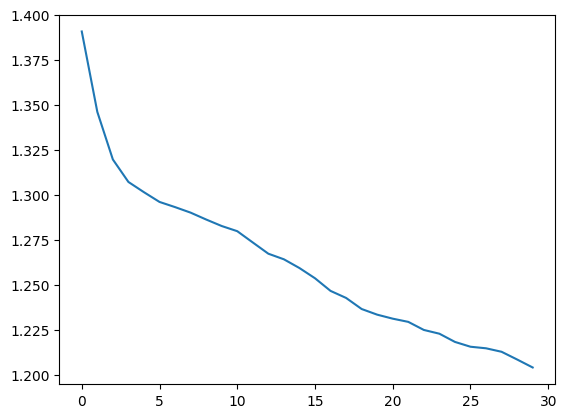

In [9]:
results = model.predict(features)
plt.plot(history.history["loss"])
plt.show()

5917/5917 [==============================] - 221s 37ms/step


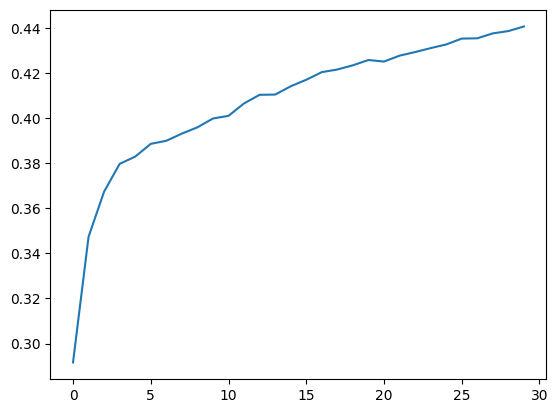

In [10]:
results = model.predict(features)
plt.plot(history.history["accuracy"])
plt.show()

In [11]:
def checkExact(features,labels,indexInIt):
    val_loss,val_acc= model.evaluate(features[indexInIt-1:indexInIt],labels[indexInIt-1:indexInIt])
    results = model.predict(features[indexInIt-1:indexInIt])[0]
    print("ИИ был", bool(int(val_acc)),"!")
    r = np.where(results==results.max())[0][0]
    print("Предполагает верной категорию ",r, "Верная категория: ", labels[indexInIt-1:indexInIt][0][0])
    print("вероятности: ",results)
    
checkExact(features,labels,-15)

1/1 [==============================] - 0s 30ms/step
ИИ был True !
Предполагает верной категорию  0 Верная категория:  0
вероятности:  [0.06017718 0.01004292 0.00569831 0.00971114]
